In [1]:
import harmonica as hm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.exposure
import xarray as xr

import magali as mg

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data_tga = mg.total_gradient_amplitude_grid(data)
data

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[  5.03989808,   5.07672275,   5.11300834, ...,  96.99888184,
         97.47836551,  97.61068787],
       [  5.07760406,   5.11469915,   5.15122308, ..., 103.2557034 ,
        103.80744457, 103.95796521],
       [  5.1156825 ,   5.15305604,   5.18982587, ..., 110.14047169,
        110.76916212, 110.93324814],
       ...,
       [ 97.86197554, 103.07210801, 108.51887287, ...,  43.60742271,
         42.34652898,  41.12652183],
       [ 92.85352054,  97.6031775 , 102.55305801, ...,  42.32116682,
         41.12149205,  39.9595163 ],
       [ 88.11730492,  92.44982627,  96.95166372, ...,  41.07216292,
         39.930909  ,  38.82438723]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [3]:
stretched = skimage.exposure.rescale_intensity(
    data_tga,
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_tga.coords)
data_tga_stretched

<xarray.DataArray (y: 1001, x: 1001)> Size: 8MB
array([[0.0605643 , 0.01592867, 0.03405744, ..., 0.0234938 , 0.0070716 ,
        0.05329862],
       [0.02002186, 0.01210878, 0.00094079, ..., 0.00369114, 0.00819043,
        0.02345864],
       [0.0371087 , 0.00317941, 0.01120208, ..., 0.01176279, 0.00279602,
        0.03805538],
       ...,
       [0.02205446, 0.00171407, 0.00882199, ..., 0.00551839, 0.00187415,
        0.02100203],
       [0.00599209, 0.00830111, 0.00360088, ..., 0.00240368, 0.00764652,
        0.00734362],
       [0.04624572, 0.0183732 , 0.0305493 , ..., 0.01948089, 0.00893436,
        0.03982636]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

### Stretch the contrast of TGA

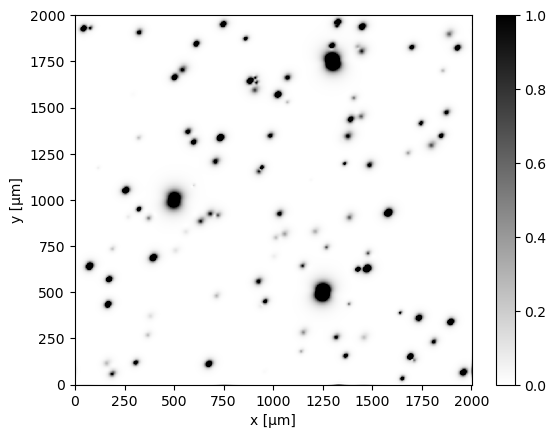

In [4]:
data_tga_stretched.plot.pcolormesh(cmap="gray_r")

## Detection

In [5]:
size_range = [25, 50]
size_increment = 1.0
threshold = 0.01
overlap = 0.3
exclude_border = 1
num_scales = 5
border_exclusion = 0
overlap_ratio = 0.3

In [6]:
windows = mg.detect_anomalies(
    data_tga_stretched,
    size_range,
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.01,
    overlap_ratio=0.5,
    border_exclusion=1,
)

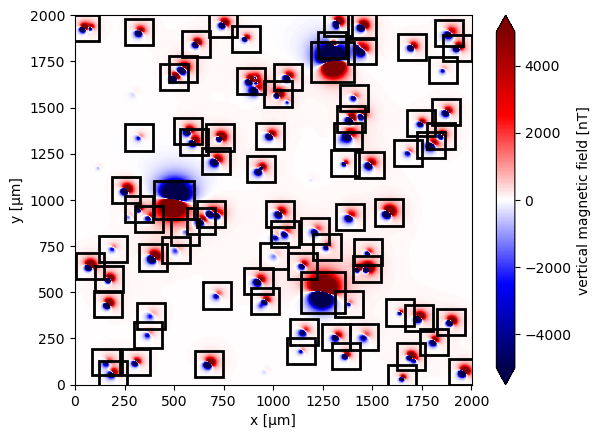

In [7]:
ax = plt.subplot(111)
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

# Write tests

In [8]:
# Synthetic
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 5

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data_tga = mg.total_gradient_amplitude_grid(data)
stretched = skimage.exposure.rescale_intensity(
    data_tga,
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_tga.coords)

# Detection
size_range = [25, 50]
size_increment = 1.0
threshold = 0.01
overlap = 0.3
exclude_border = 1
num_scales = 5
border_exclusion = 0
overlap_ratio = 0.3

windows = mg.detect_anomalies(
    data_tga_stretched,
    size_range,
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.01,
    overlap_ratio=0.5,
    border_exclusion=1,
)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


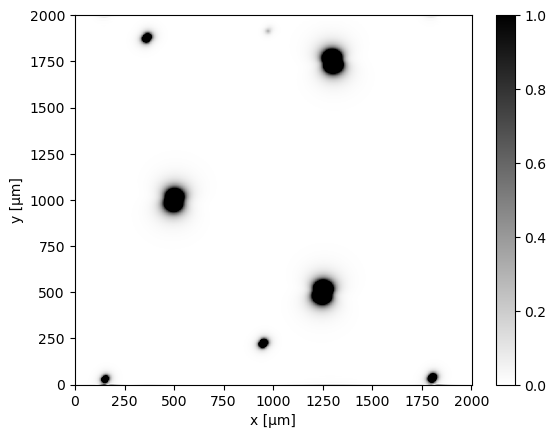

In [9]:
data_tga_stretched.plot.pcolormesh(cmap="gray_r")

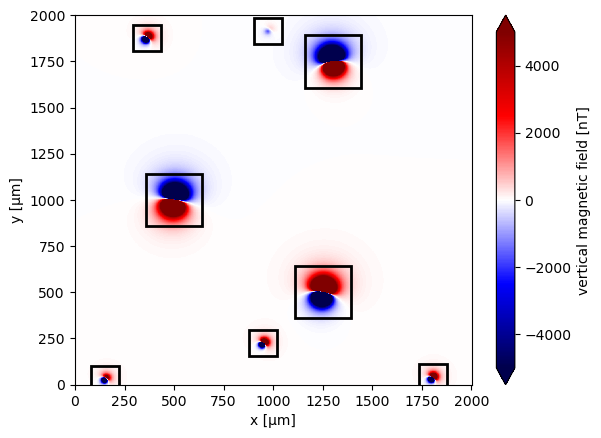

In [10]:
ax = plt.subplot(111)
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [19]:
print(len(windows)==8)
print(len(windows[0])==4)

True
True
